# load data

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd


import numpy as np
from utils import plotSettings

<Figure size 640x480 with 0 Axes>

In [5]:
from utils.opconNosepokeFunctions import *
from utils.supplementaryFunctions import *
from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.stats import ttest_rel

# import pickle 
# with open('L:/4portProb_processed/cleandf.pkl', 'rb') as f:
#     df = pickle.load(f)

sessdf = pd.read_csv('S:/fileTransferFromWindows/sessdf.csv')

window = 5
# sessdf = df
sessdf['rr'] = sessdf.groupby(['animal', 'session'], as_index = False).reward.rolling(window, center=True).mean().reward
bin_size = 50
sessdf['sess_bin'] = sessdf.groupby(['animal', 'task'])['session'].transform(lambda x: pd.cut(x, bins=range(0, x.max() + bin_size, bin_size), labels=False, right=False)+1)
# sessdf.drop(columns = 'Unnamed: 0', inplace = True)
exclude = ['[ 20  20  20 100]', '[0 0 0 0]', '[0]', '[0 0]',
    '[1000   80]', '[30]', '[40]', '[70]']
sessdf = sessdf[~sessdf.rewprobfull.isin(exclude)]
sessdf = sessdf[~(sessdf.animal == 'Raikou')]
# Remove sessions (per animal) that have any duplicated trials (rows)
# Assumes 'animal' and 'session' columns exist in sessdf

def remove_sessions_with_duplicate_trials(df, animal_col='animal', session_col='session'):
    # Find sessions (per animal) with any duplicated trials based on 'trialstart' and 'eptime'
    trial_cols = ['trialstart', 'eptime']
    to_remove = set()
    for (animal, session), group in df.groupby([animal_col, session_col]):
        # If any duplicated trial in this group, mark for removal
        if group.duplicated(subset=trial_cols, keep=False).any():
            # print(f"Session {animal}, {session} has duplicated trials based on {trial_cols}")
            to_remove.add((animal, session))
    # Build mask for rows to keep
    mask = ~(df[[animal_col, session_col]].apply(tuple, axis=1).isin(to_remove))
    return df[mask].copy()

# Apply to sessdf
sessdf = remove_sessions_with_duplicate_trials(sessdf)
an_dict = {
    'unstr'  : ['test05022023', 'Blissey', 'Chikorita', 'Darkrai', 'Eevee', 
                'Goldeen', 'Hoppip', 'Inkay', 'Jirachi', 'Kirlia', 'Mesprit',
                'Nidorina', 'Oddish', 'Phione', 'Quilava', 'Raltz', 'Shinx',
                'Togepi', 'Umbreon', 'Vulpix', 'Xatu', 'Yanma', 'Zacian',
                'Alakazam', 'Bayleef', 'Cresselia', 'Emolga', 'Giratina',
                'Haxorus', 'Ivysaur', 'Jigglypuff', 'Lugia', 'Ninetales', 'Onix',
                'Pichu', 'Quaxly', 'Sableye', 'Torchic', 'Uxie', 'Vanillish',
                'Whismur', 'Xerneas', 'Yamper', 'Zorua'],
    'dls'    : ['Blissey', 'Darkrai', 'Inkay' , 'Mesprit', 'Raltz', 'Zacian', 'Alakazam', 'Quilava', 'Torchic', 'Uxie', 'Vanillish', 'Yamper', 'Zorua'],
    'dms'    : ['Hoppip', 'Kirlia', 'Nidorina', 'Togepi', 'Xatu', 'Yanma', 'Giratina', 'Ivysaur', 'Lugia', 'Whismur', 'Quaxly', 'Sableye'],
    'sham'   : ['test05022023', 'Jirachi', 'Goldeen', 'Phione', 'Umbreon', 'Vulpix', 'Emolga', 'Haxorus', 'Jigglypuff'],
    'ds'     : ['Chikorita', 'Eevee'],
    'str'    : ['test05022023', 'Blissey', 'Chikorita', 'Darkrai', 'Eevee'],
    'oe_drive' : ['Shinx', 'Dratini', 'Bayleef', 'Onix', 'Pichu', 'Xerneas']
}

# switch prob within block n

In [25]:
#################################### switch probability in a session ######################################
%matplotlib qt
trialsinsess = 100
df = sessdf
from utils.dfLoading import subset_trials, add_shift_info
subset_df = add_shift_info(df[(df.task =='unstr') & (df.block_group==1)])
subset_df = subset_trials(subset_df, trialsinsess=trialsinsess, head_trials = trialsinsess)


from utils.dfAnalysisHelpers import session_averager
swprob_mean_dict = session_averager(subset_df, metric= 'shift_t0')

AttributeError: 'DataFrame' object has no attribute 'block_group'

In [12]:
# plot average reponse
from utils.plotSettings import *
from scipy.stats import sem
plt.figure(figsize = (5,4.5))
temp_unstr, temp_str = [], []

# set properties
smooth = False
window = 3
label1, label2 = 'Pre-lesion', 'Post-lesion'
# label1, label2 = 'Unstructured', 'Structured'
color1, color2 = 'xkcd:cornflower', 'xkcd:slate grey'
# color1, color2 = 'xkcd:pumpkin orange', 'xkcd:emerald green'
# color1, color2 = '#7a2048', '#408ec6'

# set data for plotting
cond = 'dls'
for animal in swprob_mean_dict.keys():
    # if animal in fish:
    # if env == 'unstr':
    temp_unstr.append(swprob_mean_dict[animal])
        # elif (env == 'dms'):
        #     temp_str.append(entropy_mean_dict[(animal, env)])
            
if smooth:           
    for i, row in enumerate(temp_unstr):
        temp_unstr[i] = np.convolve(row, np.ones(3)/3, 'same')
        # temp_str[i] = np.convolve(temp_str[i], np.ones(3)/3, 'same')
    #     temp_dms[i] = np.convolve(temp_dms[i], np.ones(3)/3, 'same')

    temp_unstr = np.array(temp_unstr)
    # temp_str = np.array(temp_str)

    # works only for odd windows
    temp_unstr[:, 0:(window//2)] = np.nan
    temp_unstr[:, (trialsinsess-window//2):trialsinsess] = np.nan
    
    # temp_str[:, 0:(window//2)] = np.nan
    # temp_str[:, (trialsinsess-window//2):trialsinsess] = np.nan
# 
temp_unstr = np.array(temp_unstr)
mean_unstr = (np.mean(np.array(temp_unstr), axis = 0))
# mean_str = (np.mean(np.array(temp_str), axis = 0))
# temp_str = (np.mean(np.array(temp_str), axis = 0))

plt.plot(np.arange(trialsinsess), mean_unstr, color1, label = label1) #7a2048
plt.fill_between(np.arange(trialsinsess), mean_unstr+sem(temp_unstr, nan_policy = 'omit'),
                 mean_unstr-sem(temp_unstr, nan_policy = 'omit'), color = color1, alpha = 0.2)

# plt.plot(np.arange(trialsinsess), mean_str, color2, label = label2)

# plt.fill_between(np.arange(trialsinsess),mean_str+sem(temp_str, nan_policy = 'omit'), 
#                  mean_str-sem(temp_str, nan_policy = 'omit'), color = color2, alpha = 0.2)

# pvals = ttest_rel(temp_str, temp_unstr, axis =0 , nan_policy = 'omit')[1]
# print(pvals[1].shape)
# pvals_ind = [ind for ind, i in enumerate(pvals) if i < 0.05]
# plt.scatter(pvals_ind, [0.1]*len(pvals_ind), marker = '.', color = 'r', alpha = 0.4) #(6, 2, 60) for asterisks
# plt.axhline(1.95, color = 'k', linestyle = '--') # max entropy possible
# plt.title('Variation in choice taken')
plt.xlabel('Trials in session', fontsize = 'x-large')
plt.ylabel('Switch probability', fontsize = 'x-large')
plt.xlim(0, trialsinsess)
plt.ylim(0, 0.4)
plt.xticks([0, 25, 50, 75, 100], [1, '', '', '', 100], color = 'grey', fontsize = 'large')
plt.yticks([0, 0.2, 0.4], [0, 0.2, 0.4], color = 'grey', fontsize = 'large')
plt.title(f'n = {temp_unstr.shape[0]}')
# plt.ylim(0, 0.8)
# plt.legend()
sns.despine()
# sns.set_context('talk')
plt.tight_layout()

# switch prob after block n

In [ ]:
# for all groups which have a second block, plot first block entropy for first 100 trials of session
# find if 2nd or greater block exists for animals
trialsinsess = 100
df = sessdf
from utils.dfLoading import subset_trials, add_block_groups, add_shift_info
subset_df_nohead = add_block_groups(df[df.task == 'unstr'])
subset_df_nohead = add_shift_info(subset_df_nohead)
subset_df_nohead = subset_trials(subset_df_nohead, trialsinsess=trialsinsess, head_trials=trialsinsess)


task = 'unstr'
block_2_exists = (subset_df_nohead[(subset_df_nohead.block_group>=2) & (subset_df_nohead.task == task)]
                  .groupby(['animal', 'sess_block'])
                  .size()
                  .reset_index()[['animal', 'sess_block']])

# remove animals with less than 10
block_2_exists = block_2_exists[block_2_exists.animal.isin(block_2_exists.animal.value_counts()[block_2_exists.animal.value_counts()>10].index)]

# find first blocks for these sessions
all_blocked_groups = subset_df_nohead[subset_df_nohead.task == task].merge(block_2_exists, on = ['animal', 'sess_block'])
first_blocks = all_blocked_groups[all_blocked_groups.block_group == 1]
other_blocks = all_blocked_groups[all_blocked_groups.block_group > 1]
second_blocks = all_blocked_groups[all_blocked_groups.block_group == 2]
third_blocks = all_blocked_groups[all_blocked_groups.block_group == 3]
# convert to numpy array
swprob2_dict_block_1 = {}
for an, group in first_blocks.groupby('animal'):
    g = group.groupby('session').cumcount()
    L = (group.set_index(['session', g])
            .unstack(fill_value=0)
            .stack(future_stack= True).groupby(level=0)
            .apply(lambda x: x.shift_t0.values.tolist())
            .tolist())
    swprob2_dict_block_1[an] = np.mean(L, axis = 0)
swprob2_dict_block_others = {}
for an, group in second_blocks.groupby('animal'):
    g = group.groupby('session').cumcount()
    L = (group.set_index(['session', g])
            .unstack(fill_value=0)
            .stack(future_stack= True).groupby(level=0)
            .apply(lambda x: x.shift_t0.values.tolist())
            .tolist())
    swprob2_dict_block_others[an] = np.mean(L, axis = 0)
swprob3_dict_block_others = {}
for an, group in third_blocks.groupby('animal'):
    g = group.groupby('session').cumcount()
    L = (group.set_index(['session', g])
            .unstack(fill_value=0)
            .stack(future_stack= True).groupby(level=0)
            .apply(lambda x: x.shift_t0.values.tolist())
            .tolist())
    swprob3_dict_block_others[an] = np.mean(L, axis = 0)


c:\Users\dlab\rishika_sim\utils\dfLoading.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = 0
c:\Users\dlab\rishika_sim\utils\dfLoading.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = df.groupby(['animal', 'task']).sess_block.cumsum()
c:\Users\dlab\rishika_sim\utils\dfLoading.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

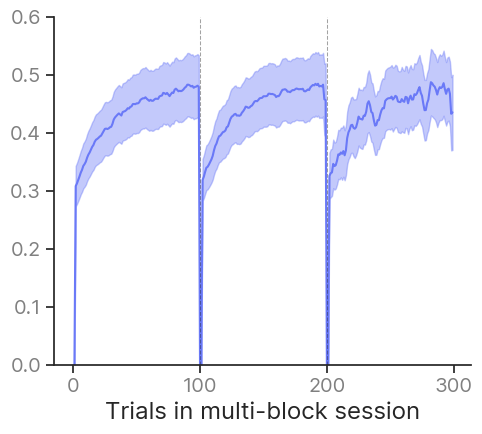

In [ ]:
from utils.plotSettings import *
from scipy.stats import sem
# %matplotlib qt
plt.figure(figsize = (5, 4.5))
prev_sess_size = 200
y = np.zeros((len(swprob2_dict_block_1.keys()), 100+prev_sess_size))
for ind, an in enumerate(swprob3_dict_block_others.keys()):
    y[ind] = np.concatenate([swprob2_dict_block_1[an][-prev_sess_size:], swprob2_dict_block_others[an], swprob3_dict_block_others[an]])
    # plt.plot(y[ind], color = 'xkcd:cornflower', alpha = 0.3, lw = 0.75)
plt.plot(np.nanmean(y, axis = 0), color = 'xkcd:cornflower')
plt.fill_between(np.arange(100+prev_sess_size), 
                np.nanmean(y, axis = 0) - sem(y, axis = 0, nan_policy='omit'),
                np.nanmean(y, axis = 0) + sem(y, axis = 0, nan_policy='omit'),
                color = 'xkcd:cornflower', alpha = 0.4)
plt.xlabel('Trials in multi-block session', fontsize = 'x-large')
plt.ylabel('Switch rate', fontsize = 'x-large')
plt.ylim(0, 0.4)
# plt.xticks(np.arange(0, prev_sess_size+101, 25), np.arange(-prev_sess_size, 101, 25), color = 'grey', fontsize = 'large')
plt.axvline(100, lw = 0.75, color = 'k', linestyle = '--', alpha = 0.4)
plt.axvline(prev_sess_size, lw = 0.75, color = 'k', linestyle = '--', alpha = 0.4)
plt.yticks(color = 'grey', fontsize = 'large')
# plt.text(prev_sess_size/4, 0.3, 'First blocks', fontsize = 'small')
# plt.text(110, 0.3, 'Other (2nd, 3rd, ...) blocks', fontsize = 'small')
sns.despine()
plt.tight_layout()

# latency to poke

In [128]:
# select for blocks 1 and 2
# plot latency between trials (on average per session) per trial at the end of the session
# for each animal, session in first block, get sess_block and block group. add 1 to get for the other 
tail_time = []
head_time = []
for ind, group in first_blocks.groupby(['animal', 'session']):
    tail_time.append(group.tail(1).trialend)
    next_sess = second_blocks[(second_blocks.animal == ind[0]) & (second_blocks.session == ind[1]+1)]
    if next_sess.empty==True:
        continue
    head_time.append(next_sess.head(1).trialstart)

In [150]:
matched = []
# tail_time = pd.concat(tail_time)
# head_time = pd.concat(head_time)
for i in tail_time.index:
    try:
        matched.append([i, tail_time.loc[i], head_time.loc[i+1]])
    except KeyError:
        matched.append([i, tail_time.loc[i], np.nan])
matched = pd.DataFrame(matched, columns = ['ind', 'tail_time', 'head_time'])

plt.figure()
ax = plt.subplot(121)
ax.hist(matched['head_time'], range = (0,10000), bins = 50, color = 'xkcd:green blue') # but this is assuming the head time also includes any diff from the session end!
ax.set_title('Reward to poke time between block 1 & 2', wrap = True)
ax.set_xlabel('Latency (ms)')
ax = plt.subplot(122)
# what about other sequential trials?
ax.hist(first_blocks['trialstart'].shift(-1)- first_blocks['trialend'], range = (0,10000), bins = 50, color = 'xkcd:green blue')
ax.set_title('Reward to poke time within block 1', wrap = True)
ax.set_xlabel('Latency (ms)')
plt.tight_layout()

# switch prob on first trial of block

In [240]:
first_switch = (pd.concat([first_blocks.groupby(['animal', 'session']).head(1).groupby(['animal', 'session']).shift_t0.mean().groupby('animal').mean(),
                           second_blocks.groupby(['animal', 'session']).head(1).groupby(['animal', 'session']).shift_t0.mean().groupby('animal').mean(),
                           third_blocks.groupby(['animal', 'session']).head(1).groupby(['animal', 'session']).shift_t0.mean().groupby('animal').mean()],
                          axis = 1)
                          .dropna()
                          .reset_index()
                          )
first_switch.columns.values[1]='Block 1'
first_switch.columns.values[2]='Block 2'
first_switch.columns.values[3]='Block 3'
sns.stripplot(first_switch, palette = 'crest', s=7, alpha = 0.4)
sns.pointplot(first_switch, linestyle = 'None', errorbar=None, color = 'k')
plt.ylabel('Switch prob on first trial')
plt.tight_layout()

# switch prob after RR/NR/RN/NN

In [151]:
from utils.dfAnalysisHelpers import subset_metric_to_numpy
subset_df['reward_t1'] = subset_df.groupby(['animal', 'session']).reward.shift(1)
cat_df = pd.DataFrame()
cat_df[['reward_t0', 'reward_t1', 'session', 'animal', 'shift_t0', 'disp']] = subset_df[['reward', 'reward_t1', 'session', 'animal', 'shift_t0', 'disp']]
cat_df.dropna(inplace=True)

cat_df['r_cat2'] = cat_df['reward_t1'].astype(int).astype(str)+cat_df['reward_t0'].astype(int).astype(str)

In [155]:
# plt.figure()
mat = cat_df.groupby(['animal', 'session', 'r_cat2'])['shift_t0'].mean().unstack().groupby('animal').mean()
sns.stripplot(mat.stack().reset_index(), x = 'r_cat2', hue = 'animal', y=0, legend=False, palette = 'crest', alpha = 0.4)
sns.pointplot(mat, errorbar = None, linestyle='None', color = 'k')
plt.xticks(np.arange(0, 4),['NN', 'NR', 'RN', 'RR'] )
plt.ylabel('Switch probability')
plt.xlabel(r'Reward sequence ($R_{t-1}R_{t}$)')
sns.despine()
plt.tight_layout()

In [157]:
plt.figure()
cat_df['disp'] = abs(cat_df.disp)
mat = cat_df[cat_df.shift_t0==1].groupby(['animal', 'session', 'r_cat2'])['disp'].mean().unstack().groupby('animal').mean()
sns.stripplot(mat.stack().reset_index(), x = 'r_cat2', hue = 'animal', y=0, legend=False, palette = 'crest', alpha = 0.4)
sns.pointplot(mat, errorbar = None, linestyle='None', color = 'k')
plt.xticks(np.arange(0, 4),['NN', 'NR', 'RN', 'RR'] )
plt.ylabel('Switch distance')
plt.xlabel(r'Reward sequence ($R_{t-1}R_{t}$)')
plt.title('Switches only')
sns.despine()
plt.tight_layout()

In [158]:
# after triplet
subset_df['reward_t2'] = subset_df.groupby(['animal', 'session']).reward.shift(2)
cat_df['reward_t2'] = subset_df['reward_t2']
cat_df.dropna(inplace=True)

cat_df['r_cat3'] = cat_df['reward_t2'].astype(int).astype(str)+cat_df['reward_t1'].astype(int).astype(str)+cat_df['reward_t0'].astype(int).astype(str)

In [162]:
mat = cat_df.groupby(['animal', 'session', 'r_cat3'])['shift_t0'].mean().unstack().groupby('animal').mean()
sns.stripplot(mat.stack().reset_index(), x = 'r_cat3', hue = 'animal', y=0, legend=False, palette = 'crest', alpha = 0.4)
sns.pointplot(mat, errorbar = None, linestyle='None', color = 'k')
plt.xticks(np.arange(0, 8),['NNN', 'NNR', 'NRN', 'NRR', 'RNN', 'RNR', 'RRN', 'RRR'])
plt.ylabel('Switch probability')
plt.xlabel(r'Reward sequence ($R_{t-2}R_{t-1}R_{t}$)')
sns.despine()
plt.tight_layout()

In [163]:
mat = cat_df.groupby(['animal', 'session', 'r_cat3'])['disp'].mean().unstack().groupby('animal').mean()
sns.stripplot(mat.stack().reset_index(), x = 'r_cat3', hue = 'animal', y=0, legend=False, palette = 'crest', alpha = 0.4)
sns.pointplot(mat, errorbar = None, linestyle='None', color = 'k')
plt.xticks(np.arange(0, 8),['NNN', 'NNR', 'NRN', 'NRR', 'RNN', 'RNR', 'RRN', 'RRR'])
plt.ylabel('Switch distance')
plt.xlabel(r'Reward sequence ($R_{t-2}R_{t-1}R_{t}$)')
plt.title('All trials')
sns.despine()
plt.tight_layout()

In [164]:
mat = cat_df[cat_df.shift_t0==1].groupby(['animal', 'session', 'r_cat3'])['disp'].mean().unstack().groupby('animal').mean()
sns.stripplot(mat.stack().reset_index(), x = 'r_cat3', hue = 'animal', y=0, legend=False, palette = 'crest', alpha = 0.4)
sns.pointplot(mat, errorbar = None, linestyle='None', color = 'k')
plt.xticks(np.arange(0, 8),['NNN', 'NNR', 'NRN', 'NRR', 'RNN', 'RNR', 'RRN', 'RRR'])
plt.ylabel('Switch distance')
plt.xlabel(r'Reward sequence ($R_{t-2}R_{t-1}R_{t}$)')
plt.title('Switches only')
sns.despine()
plt.tight_layout()

# block transition comparisons - cued vs uncued

In [1]:
# select block 3 transitions with > 25 trials
from utils.dfLoading import add_block_groups
df = add_block_groups(df[df.task == 'unstr'])
bl3 = (
    df[(df.block_group == 1) & (df.task == 'unstr')]
       .groupby(['animal', 'session'])
       .trial
       .count()[df[(df.block_group == 1) & (df.task == 'unstr')]
                .groupby(['animal', 'session'])
                .trial
                .count()>100]
                .index
                .to_numpy()
                )
bl3_head = np.zeros(shape = (bl3.shape[0], 25))
bl2_tail = np.zeros(shape = (bl3.shape[0], 50))
bl2_head = np.zeros(shape = (bl3.shape[0], 100))
bl1_tail = np.zeros(shape = (bl3.shape[0], 50))
bl1_head = np.zeros(shape = (bl3.shape[0], 100))

empty_row = []
# for row, i in enumerate(bl3):
#     if ((df[(df.animal == i[0]) & (df.session == i[1]-2)].trial.count()<100)==True):
#         empty_row.append(row)
#         print(row)
#     elif ((df[(df.animal == i[0]) & (df.session == i[1]-1)].trial.count()<100)==True):
#         empty_row.append(row)
#         print(row)
#     else:
#     # bl3
#         bl3_head[row] = df[(df.animal == i[0]) & (df.session == i[1])].head(25).port
#     # bl2 
#         bl2_head[row] = df[(df.animal == i[0]) & (df.session == i[1]-1)].head(50).port
#         bl2_tail[row] = df[(df.animal == i[0]) & (df.session == i[1]-1)].tail(50).port
#     # bl1 
#         bl1_tail[row] = df[(df.animal == i[0]) & (df.session == i[1]-2)].tail(50).port

grouped = dict(tuple(df.groupby(['animal', 'session'])))
for row, i in enumerate(bl3):
    key_bl3 = (i[0], i[1])
    key_bl2 = (i[0], i[1]-1)
    key_bl1 = (i[0], i[1]-2)
    if key_bl1 not in grouped or grouped[key_bl1].trial.count() < 100:
        empty_row.append(row)
        print(row)
    elif key_bl2 not in grouped or grouped[key_bl2].trial.count() < 100:
        empty_row.append(row)
        print(row)
    else:
        bl3_head[row] = grouped[key_bl3].head(25).port
        bl2_head[row] = grouped[key_bl2].head(100).port
        bl2_tail[row] = grouped[key_bl2].tail(50).port
        bl1_tail[row] = grouped[key_bl1].tail(50).port
        bl1_head[row] = grouped[key_bl1].head(100).port
bl3_head[empty_row]= np.nan
bl2_head[empty_row]= np.nan
bl2_tail[empty_row]= np.nan
bl1_tail[empty_row]= np.nan
bl1_head[empty_row]= np.nan


NameError: name 'df' is not defined

In [19]:
from utils.plotSettings import *
from scipy.stats import sem
%matplotlib qt
# each animal in switch_array
an_ = np.array([val for i, val in enumerate(bl3) if i not in empty_row])[:, 0]
switch_arr = np.abs(np.diff(bl1_head))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr == 0] = np.nan

# keep rows without NaNs and align an_ with switch_arr
mask = ~np.isnan(switch_arr).all(axis=1)
switch_arr = switch_arr[mask]
an_filtered = an_[mask]

from collections import defaultdict
grouped = defaultdict(list)
for animal, row in zip(an_filtered, switch_arr):
    grouped[animal].append(row)

# per-animal mean & sem (stack rows for each animal)
group_mean = {k: np.nanmean(np.vstack(v), axis=0) for k, v in grouped.items()}

# mean across animals (average of per-animal means)
mean_across_animals = np.nanmean(np.vstack(list(group_mean.values())), axis=0)
sem_across_animals = sem(np.vstack(list(group_mean.values())), axis=0, nan_policy='omit')

smooth = True
window = 3
temp_unstr = np.ones(shape = (len(group_mean.keys()), 99))*np.nan
trialsinsess = 99
# smoothing details
if smooth:           
    for i, row in enumerate(np.array(list(group_mean.values()))):
        temp_unstr[i] = np.convolve(row, np.ones(window)/window, 'same')
    
    # works only for odd windows
    temp_unstr[:, 0:(window//2)] = np.nan
    temp_unstr[:, (trialsinsess-window//2):trialsinsess] = np.nan

    mean_across_animals = np.nanmean(temp_unstr, axis = 0)
    sem_across_animals = sem(temp_unstr, axis = 0, nan_policy='omit')

# plot per-animal traces and the group average
plt.figure(figsize = (5,4.5))
plt.plot(mean_across_animals, color='xkcd:cornflower')
plt.fill_between(np.arange(mean_across_animals.size),
                 mean_across_animals - sem_across_animals,
                 mean_across_animals + sem_across_animals,
                 color='xkcd:cornflower', alpha=0.3)
plt.xlabel('Trials in session')
plt.xticks(np.arange(0, 101, 25), [1, '', '', '', 100])
plt.title(f'n = {len(group_mean)}')
plt.ylabel('Switch distance')
# plt.legend()
plt.tight_layout()

C:\Users\dlab\AppData\Local\Temp\ipykernel_3704\245088915.py:21: RuntimeWarning: Mean of empty slice
  group_mean = {k: np.nanmean(np.vstack(v), axis=0) for k, v in grouped.items()}
C:\Users\dlab\AppData\Local\Temp\ipykernel_3704\245088915.py:40: RuntimeWarning: Mean of empty slice
  mean_across_animals = np.nanmean(temp_unstr, axis = 0)
C:\Users\dlab\AppData\Local\Temp\ipykernel_3704\245088915.py:41: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  sem_across_animals = sem(temp_unstr, axis = 0, nan_policy='omit')


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
%matplotlib qt

# each animal in switch_array
an_ = np.array([val for i, val in enumerate(bl3) if i not in empty_row])[:, 0]

# plot difference between cued and uncued choices
switch_arr = np.diff(np.concatenate([bl1_tail, bl2_head], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[0],  
    # marker = '.',
    label = 'cued'
    )
ax.fill_between(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
    np.mean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
    color = sns.color_palette('crest')[0], 
    label = None, 
    alpha = 0.4
    )
ax.axvline(50, linestyle ='--', color = 'grey')
# ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])

switch_arr = np.diff(np.concatenate([bl2_tail, bl3_head], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[4],  
    # marker = '.',
    label = 'uncued'
    )
ax.fill_between(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
    np.mean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
    color = sns.color_palette('crest')[4], 
    label = None, 
    alpha = 0.4
    )
ax.set_xticks(np.arange(0, 101, 25)-0.5, [-50, -25, 0, 25, 50])
ax.set_xlabel('Trials across blocks')
ax.set_ylabel('Switch rate')
ax.axvline(49.5, linestyle ='--', color = 'grey')
leg = ax.legend(frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.tight_layout()

In [21]:
# plot big switch rate 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
%matplotlib qt

# each animal in switch_array
an_ = np.array([val for i, val in enumerate(bl3) if i not in empty_row])[:, 0]

# plot difference between cued and uncued choices
switch_arr = np.diff(np.concatenate([bl1_head, bl1_tail, bl2_head[:, :25]], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1
switch_arr[:, 99] = np.nan
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.nanmean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[1],  
    marker = '.',
    label = 'block 1 to 2'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.nanmean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.nanmean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[1], 
#     label = None, 
#     alpha = 0.4
#     )
ax.axvline(150, linestyle ='--', color = 'grey')
# ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])

switch_arr = np.diff(np.concatenate([bl2_head, bl2_tail, bl3_head], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1
switch_arr[:, 99] = np.nan

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.nanmean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[5],  
    marker = '.',
    label = 'block 2 to 3'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.nanmean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.nanmean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[5], 
#     label = None, 
#     alpha = 0.4
#     )
# ax.set_xticks(np.arange(0, 101, 25)-0.5, [-50, -25, 0, 25, 50])
ax.set_xlabel('Trials across blocks')
ax.set_ylabel('Switch rate')
# ax.axvline(49.5, linestyle ='--', color = 'grey')
leg = ax.legend(frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

# to add a kink after bl1head
false_zero = bl1_head.shape[1]

# make the original axis disappear
ax.spines['bottom'].set_visible(False)
# draw a kink + x-axis line
ax.add_line(plt.Line2D(xdata=[-5, false_zero-2, false_zero, false_zero, false_zero + 2, switch_arr.shape[1]+1],
                       ydata=[0, 0, 0.03, -0.03, 0, 0],
                       color=ax.spines['bottom'].get_edgecolor(), lw=ax.spines['bottom'].get_linewidth(),
                       clip_on=False, transform=ax.get_xaxis_transform()))

ax.text(x = 145, y = ax.get_ylim()[1]-0.175, s= 'probability change', rotation = 90, color = 'grey')

ax.set_xlim(-5, switch_arr.shape[1]+5)
plt.tight_layout()

C:\Users\dlab\AppData\Local\Temp\ipykernel_3704\2995309048.py:20: RuntimeWarning: Mean of empty slice
  np.nanmean(switch_arr, axis = 0),
C:\Users\dlab\AppData\Local\Temp\ipykernel_3704\2995309048.py:43: RuntimeWarning: Mean of empty slice
  np.nanmean(switch_arr, axis = 0),


In [166]:
# switch distances also!
switch_arr = np.abs(np.diff(np.concatenate([bl1_head, bl1_tail, bl2_head[:, :25]], axis = 1)))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
# switch_arr[switch_arr==0]=np.nan
switch_arr[:, 99] = np.nan
switch_arr[:, 148] = np.nan

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.nanmean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[1],  
    # marker = '.',
    label = 'block 1 to 2'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.nanmean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.nanmean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[1], 
#     label = None, 
#     alpha = 0.4
#     )
ax.axvline(150, linestyle ='--', color = 'grey')
# ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])

switch_arr = np.abs(np.diff(np.concatenate([bl2_head, bl2_tail, bl3_head], axis = 1)))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
# switch_arr[switch_arr==0]=np.nan
switch_arr[:, 99] = np.nan
switch_arr[:, 148] = np.nan


ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.nanmean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[5],  
    # marker = '.',
    label = 'block 2 to 3'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.nanmean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.nanmean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[5], 
#     label = None, 
#     alpha = 0.4
#     )
# ax.set_xticks(np.arange(0, 101, 25)-0.5, [-50, -25, 0, 25, 50])
ax.set_xlabel('Trials across blocks')
ax.set_ylabel('Switch distance')
# ax.axvline(49.5, linestyle ='--', color = 'grey')
leg = ax.legend(frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

# to add a kink after bl1head
false_zero = bl1_head.shape[1]

# make the original axis disappear
ax.spines['bottom'].set_visible(False)
# draw a kink + x-axis line
ax.add_line(plt.Line2D(xdata=[-5, false_zero-2, false_zero, false_zero, false_zero + 2, switch_arr.shape[1]+1],
                       ydata=[0, 0, 0.03, -0.03, 0, 0],
                       color=ax.spines['bottom'].get_edgecolor(), lw=ax.spines['bottom'].get_linewidth(),
                       clip_on=False, transform=ax.get_xaxis_transform()))

ax.text(x = 145, y = ax.get_ylim()[1]-0.175, s= 'probability change', rotation = 90, color = 'grey')

ax.set_xlim(-5, switch_arr.shape[1]+5)
plt.tight_layout()

C:\Users\dlab\AppData\Local\Temp\ipykernel_11024\3868234540.py:13: RuntimeWarning: Mean of empty slice
  np.nanmean(switch_arr, axis = 0),
C:\Users\dlab\AppData\Local\Temp\ipykernel_11024\3868234540.py:38: RuntimeWarning: Mean of empty slice
  np.nanmean(switch_arr, axis = 0),


## old

In [317]:
# select for blocks 1 and 2
# plot latency between trials (on average per session) per trial at the end of the session
# for each animal, session in first block, get sess_block and block group. add 1 to get for the other 
tail_switches = np.zeros(shape = (first_blocks.groupby(['animal', 'session']).count().shape[0], 51))
head_switches = np.zeros(shape = (first_blocks.groupby(['animal', 'session']).count().shape[0], 51))
for ind, (an, group) in enumerate(first_blocks.groupby(['animal', 'session'])):
    next_sess = second_blocks[(second_blocks.animal == an[0]) & (second_blocks.session == an[1]+1)]
    if next_sess.empty==True:
        continue
    tail_switches[ind] = group.tail(51).port
    head_switches[ind] = next_sess.head(51).port

In [318]:
switch_arr = np.diff(np.concatenate([tail_switches, head_switches], axis = 1))
switch_arr[switch_arr!=0]=1
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0), 
    marker = '.',
    color = sns.color_palette('crest')[0],  
    label = 'cued'
    )
ax.axvline(50, linestyle ='--', color = 'grey')
ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])

In [319]:
tail_switches = np.zeros(shape = (second_blocks.groupby(['animal', 'session']).count().shape[0], 51))
head_switches = np.zeros(shape = (second_blocks.groupby(['animal', 'session']).count().shape[0], 51))
for ind, (an, group) in enumerate(second_blocks.groupby(['animal', 'session'])):
    next_sess = third_blocks[(third_blocks.animal == an[0]) & (third_blocks.session == an[1]+1)]
    if next_sess.empty==True:
        continue
    tail_switches[ind] = group.tail(51).port
    head_switches[ind] = next_sess.head(51).port

In [320]:
switch_arr = np.diff(np.concatenate([tail_switches, head_switches], axis = 1))
switch_arr[switch_arr!=0]=1
ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5, 
    np.mean(switch_arr, axis = 0), 
    marker = '.',
    color = sns.color_palette('crest')[1],  
    label = 'uncued'
    )
ax.axvline(50, linestyle ='--', color = 'grey')
ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])
# change the font colors to match the line colors:
leg = ax.legend()
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.show()
# leg = ax.legend(handlelength=0)

# rp change at block change

## id if current max rp changed

In [3]:
rpfull = df['rewprobfull'].apply(lambda x: np.array(x.strip('[]').split(), dtype= int)).tolist()
rpfull = pd.DataFrame(rpfull, dtype = float).to_numpy()
df['maxport'] = np.argmax(rpfull, axis = 1)+1

In [13]:
# take pairs of sessions whose maxport is not same as maxport in 2nd block 
# select block 3 transitions with > 25 trials
trialsinsess = 100

from utils.dfLoading import subset_trials, add_block_groups
subset_df_nohead = add_block_groups(df[df.task == 'unstr'])
subset_df_nohead = subset_trials(subset_df_nohead, trialsinsess=trialsinsess)


task = 'unstr'
block_2_exists = (subset_df_nohead[(subset_df_nohead.block_group>=2) & (subset_df_nohead.task == task)]
                  .groupby(['animal', 'sess_block'])
                  .size()
                  .reset_index()[['animal', 'sess_block']])

# remove animals with less than 10
block_2_exists = block_2_exists[block_2_exists.animal.isin(block_2_exists.animal.value_counts()[block_2_exists.animal.value_counts()>10].index)]

# find first blocks for these sessions
all_blocked_groups = subset_df_nohead[subset_df_nohead.task == task].merge(block_2_exists, on = ['animal', 'sess_block'])
bl2 = (
    all_blocked_groups[(all_blocked_groups.block_group == 2) & (all_blocked_groups.task == 'unstr')]
       .groupby(['animal', 'session'])
       .trial
       .count()[all_blocked_groups[(all_blocked_groups.block_group == 2) & (all_blocked_groups.task == 'unstr')]
                .groupby(['animal', 'session'])
                .trial
                .count()>100]
                .index
                .to_numpy()
                )
grouped = dict(tuple(all_blocked_groups.groupby(['animal', 'session'])))
empty_row = []
bl1_tail = np.zeros(shape = (bl2.shape[0], 100))
bl1_head = np.zeros(shape = (bl2.shape[0], 100))
bl2_head = np.zeros(shape = (bl2.shape[0], 100))
eq_rp, uneq_rp = [], []
for row, i in enumerate(bl2):
    key_bl2 = (i[0], i[1])
    key_bl1 = (i[0], i[1]-1)
    if key_bl1 not in grouped or grouped[key_bl1].trial.count() < 150:
        empty_row.append(row)
        print(row)
    else:
        if grouped[key_bl1].maxport.head(1).values == grouped[key_bl2].maxport.head(1).values:
            bl1_tail[row] = grouped[key_bl1].tail(100).port
            bl1_head[row] = grouped[key_bl1].head(100).port
            bl2_head[row] = grouped[key_bl2].head(100).port
            eq_rp.append(row)
        else: 
            bl1_tail[row] = grouped[key_bl1].tail(100).port
            bl1_head[row] = grouped[key_bl1].head(100).port
            bl2_head[row] = grouped[key_bl2].head(100).port
            uneq_rp.append(row)

bl2_head[empty_row]= np.nan
bl1_tail[empty_row]= np.nan
bl1_tail[empty_row]= np.nan

316
386
439
440
449
496
507
509
515
520
1394
1889
1918
2480
2481


In [18]:
switch_arr = np.diff(np.concatenate([bl1_tail[uneq_rp], bl2_head[uneq_rp]], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[2],  
    marker = '.',
    label = 'different high'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.mean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.mean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[0], 
#     label = None, 
#     alpha = 0.4
#     )
# ax.axvline(50, linestyle ='--', color = 'grey')
# ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])

switch_arr = np.diff(np.concatenate([bl1_tail[eq_rp], bl2_head[eq_rp]], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[5],  
    marker = '.',
    label = 'same high'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.mean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.mean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[4], 
#     label = None, 
#     alpha = 0.4
#     )
ax.set_xticks(np.arange(0, 201, 25)-0.5, np.arange(-100, 101, 25))
ax.set_xlabel('Trials across blocks')
ax.set_ylabel('Switch probability')
ax.axvline(99.5, linestyle ='--', color = 'grey')
leg = ax.legend(frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.tight_layout()

In [19]:
# take pairs of sessions (uncued) whose maxport is not same as maxport in 2nd block 
# select block 3 transitions with > 25 trials
trialsinsess = 100

# from utils.dfLoading import subset_trials, add_block_groups
# subset_df_nohead = add_block_groups(df[df.task == 'unstr'])
# subset_df_nohead = subset_trials(subset_df_nohead, trialsinsess=trialsinsess)


task = 'unstr'
block_3_exists = (subset_df_nohead[(subset_df_nohead.block_group>=3) & (subset_df_nohead.task == task)]
                  .groupby(['animal', 'sess_block'])
                  .size()
                  .reset_index()[['animal', 'sess_block']])

# remove animals with less than 10
block_3_exists = block_3_exists[block_3_exists.animal.isin(block_3_exists.animal.value_counts()[block_3_exists.animal.value_counts()>10].index)]

# find first blocks for these sessions
all_blocked_groups = subset_df_nohead[subset_df_nohead.task == task].merge(block_3_exists, on = ['animal', 'sess_block'])
bl3 = (
    all_blocked_groups[(all_blocked_groups.block_group == 3) & (all_blocked_groups.task == 'unstr')]
       .groupby(['animal', 'session'])
       .trial
       .count()[all_blocked_groups[(all_blocked_groups.block_group == 3) & (all_blocked_groups.task == 'unstr')]
                .groupby(['animal', 'session'])
                .trial
                .count()>100]
                .index
                .to_numpy()
                )
grouped = dict(tuple(all_blocked_groups.groupby(['animal', 'session'])))
empty_row = []
bl1_tail = np.zeros(shape = (bl3.shape[0], 100))
bl1_head = np.zeros(shape = (bl3.shape[0], 100))
bl2_head = np.zeros(shape = (bl3.shape[0], 100))
eq_rp, uneq_rp = [], []
for row, i in enumerate(bl3):
    key_bl2 = (i[0], i[1])
    key_bl1 = (i[0], i[1]-1)
    if key_bl1 not in grouped or grouped[key_bl1].trial.count() < 150:
        empty_row.append(row)
        print(row)
    else:
        if grouped[key_bl1].maxport.head(1).values == grouped[key_bl2].maxport.head(1).values:
            bl1_tail[row] = grouped[key_bl1].tail(100).port
            bl1_head[row] = grouped[key_bl1].head(100).port
            bl2_head[row] = grouped[key_bl2].head(100).port
            eq_rp.append(row)
        else: 
            bl1_tail[row] = grouped[key_bl1].tail(100).port
            bl1_head[row] = grouped[key_bl1].head(100).port
            bl2_head[row] = grouped[key_bl2].head(100).port
            uneq_rp.append(row)

bl2_head[empty_row]= np.nan
bl1_tail[empty_row]= np.nan
bl1_tail[empty_row]= np.nan

129
892


In [20]:
switch_arr = np.diff(np.concatenate([bl1_tail[uneq_rp], bl2_head[uneq_rp]], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[2],  
    marker = '.',
    label = 'different high'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.mean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.mean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[0], 
#     label = None, 
#     alpha = 0.4
#     )
# ax.axvline(50, linestyle ='--', color = 'grey')
# ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])

switch_arr = np.diff(np.concatenate([bl1_tail[eq_rp], bl2_head[eq_rp]], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.mean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[5],  
    marker = '.',
    label = 'same high'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.mean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.mean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[4], 
#     label = None, 
#     alpha = 0.4
#     )
ax.set_xticks(np.arange(0, 201, 25)-0.5, np.arange(-100, 101, 25))
ax.set_xlabel('Trials across blocks')
ax.set_ylabel('Switch probability')
ax.axvline(99.5, linestyle ='--', color = 'grey')
leg = ax.legend(frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.tight_layout()

# block changes after lesions

In [41]:
# select block 3 transitions with > 25 trials
from utils.dfLoading import add_block_groups
les_df = add_block_groups(df[df.task == 'dls'])
bl3 = (
    les_df[(les_df.block_group == 3) & (les_df.task == 'dls')]
       .groupby(['animal', 'session'])
       .trial
       .count()[les_df[(les_df.block_group == 3) & (les_df.task == 'dls')]
                .groupby(['animal', 'session'])
                .trial
                .count()>25]
                .index
                .to_numpy()
                )
bl3_head = np.zeros(shape = (bl3.shape[0], 25))
bl2_tail = np.zeros(shape = (bl3.shape[0], 50))
bl2_head = np.zeros(shape = (bl3.shape[0], 100))
bl1_tail = np.zeros(shape = (bl3.shape[0], 50))
bl1_head = np.zeros(shape = (bl3.shape[0], 100))

empty_row = []
# for row, i in enumerate(bl3):
#     if ((les_df[(les_df.animal == i[0]) & (les_df.session == i[1]-2)].trial.count()<100)==True):
#         empty_row.append(row)
#         print(row)
#     elif ((les_df[(les_df.animal == i[0]) & (les_df.session == i[1]-1)].trial.count()<100)==True):
#         empty_row.append(row)
#         print(row)
#     else:
#     # bl3
#         bl3_head[row] = les_df[(les_df.animal == i[0]) & (les_df.session == i[1])].head(25).port
#     # bl2 
#         bl2_head[row] = les_df[(les_df.animal == i[0]) & (les_df.session == i[1]-1)].head(50).port
#         bl2_tail[row] = les_df[(les_df.animal == i[0]) & (les_df.session == i[1]-1)].tail(50).port
#     # bl1 
#         bl1_tail[row] = les_df[(les_df.animal == i[0]) & (les_df.session == i[1]-2)].tail(50).port

grouped = dict(tuple(les_df.groupby(['animal', 'session'])))
for row, i in enumerate(bl3):
    key_bl3 = (i[0], i[1])
    key_bl2 = (i[0], i[1]-1)
    key_bl1 = (i[0], i[1]-2)
    if key_bl1 not in grouped or grouped[key_bl1].trial.count() < 100:
        empty_row.append(row)
        print(row)
    elif key_bl2 not in grouped or grouped[key_bl2].trial.count() < 100:
        empty_row.append(row)
        print(row)
    else:
        bl3_head[row] = grouped[key_bl3].head(25).port
        bl2_head[row] = grouped[key_bl2].head(100).port
        bl2_tail[row] = grouped[key_bl2].tail(50).port
        bl1_tail[row] = grouped[key_bl1].tail(50).port
        bl1_head[row] = grouped[key_bl1].head(100).port
bl3_head[empty_row]= np.nan
bl2_head[empty_row]= np.nan
bl2_tail[empty_row]= np.nan
bl1_tail[empty_row]= np.nan
bl1_head[empty_row]= np.nan


c:\Users\dlab\rishika_sim\utils\dfLoading.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = 0
c:\Users\dlab\rishika_sim\utils\dfLoading.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = df.groupby(['animal', 'task']).sess_block.cumsum()
c:\Users\dlab\rishika_sim\utils\dfLoading.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

2
41


In [26]:
# plot big switch rate 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
%matplotlib qt

# each animal in switch_array
an_ = np.array([val for i, val in enumerate(bl3) if i not in empty_row])[:, 0]

# plot difference between cued and uncued choices
switch_arr = np.diff(np.concatenate([bl1_head, bl1_tail, bl2_head[:, :25]], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1
switch_arr[:, 99] = np.nan
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.nanmean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[1],  
    marker = '.',
    label = 'block 1 to 2'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.nanmean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.nanmean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[1], 
#     label = None, 
#     alpha = 0.4
#     )
ax.axvline(150, linestyle ='--', color = 'grey')
# ax.set_xticks(np.arange(0, 101, 25), [-50, 25, 0, 25, 50])

switch_arr = np.diff(np.concatenate([bl2_head, bl2_tail, bl3_head], axis = 1))
switch_arr = switch_arr[~np.isnan(switch_arr).any(axis=1)]
switch_arr[switch_arr!=0]=1
switch_arr[:, 99] = np.nan

ax.plot(
    np.arange(stop=switch_arr.shape[1])+0.5,
    np.nanmean(switch_arr, axis = 0), 
    color = sns.color_palette('crest')[5],  
    marker = '.',
    label = 'block 2 to 3'
    )
# ax.fill_between(
#     np.arange(stop=switch_arr.shape[1])+0.5,
#     np.nanmean(switch_arr, axis = 0)-sem(switch_arr, axis = 0, nan_policy='omit'), 
#     np.nanmean(switch_arr, axis = 0)+sem(switch_arr, axis = 0, nan_policy='omit'), 
#     color = sns.color_palette('crest')[5], 
#     label = None, 
#     alpha = 0.4
#     )
# ax.set_xticks(np.arange(0, 101, 25)-0.5, [-50, -25, 0, 25, 50])
ax.set_xlabel('Trials across blocks')
ax.set_ylabel('Switch rate')
# ax.axvline(49.5, linestyle ='--', color = 'grey')
leg = ax.legend(frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

# to add a kink after bl1head
false_zero = bl1_head.shape[1]

# make the original axis disappear
ax.spines['bottom'].set_visible(False)
# draw a kink + x-axis line
ax.add_line(plt.Line2D(xdata=[-5, false_zero-2, false_zero, false_zero, false_zero + 2, switch_arr.shape[1]+1],
                       ydata=[0, 0, 0.03, -0.03, 0, 0],
                       color=ax.spines['bottom'].get_edgecolor(), lw=ax.spines['bottom'].get_linewidth(),
                       clip_on=False, transform=ax.get_xaxis_transform()))

ax.text(x = 145, y = ax.get_ylim()[1]-0.175, s= 'probability change', rotation = 90, color = 'grey')

ax.set_xlim(-5, switch_arr.shape[1]+5)
plt.tight_layout()

C:\Users\dlab\AppData\Local\Temp\ipykernel_27300\2995309048.py:20: RuntimeWarning: Mean of empty slice
  np.nanmean(switch_arr, axis = 0),
C:\Users\dlab\AppData\Local\Temp\ipykernel_27300\2995309048.py:43: RuntimeWarning: Mean of empty slice
  np.nanmean(switch_arr, axis = 0),


In [42]:
# entropy in all first blocks vs entropy in all other blocks
#################################### moving entropy ######################################
from scipy.stats import entropy
from utils.supplementaryFunctions import calc_prob
%matplotlib qt
window = 5
trialsinsess = 50
fig = plt.figure(figsize=(20,10))


entropy_mean_sess_dict = {}
i = 'dls' 
colors ={'str':'#408ec6', 'unstr':'#7a2048', 'dls':'xkcd:gold', 'dms':'xkcd:red', 'sham':'b', 'ds':'xkcd:orange'} 
# for i in ['unstr', 'str', 'dms', 'dls', 'sham']:
for ind, (animal, group) in enumerate(les_df[les_df.block_group==1].groupby('animal')):
    ax = plt.subplot(5, 7, ind+1)

    # if i == 'unstr':
    #     group = group[group.sess_bin>=4]
    
    # filter by sessions>= length
    filtered = (group[group.task.isin([i])]
                .groupby('session')).filter(lambda x: x.reward.size >= trialsinsess)

    # take only those sessions
    filtered = filtered.groupby('session').head(trialsinsess)
    
    if filtered.empty==True:
        continue
        
    # convert to numpy array
    g = filtered.groupby('session').cumcount()
    L = np.array(filtered.set_index(['session',g])
            .unstack(fill_value=0)
            .stack(future_stack=True).groupby(level=0)
            .apply(lambda x: x.port.values.tolist())
            .tolist())
    # mean
    entropy_trial = [entropy(calc_prob(L[:, col]), base = 2) for col in range(L.shape[1])]
    entropy_mean_sess_dict[animal, i] = entropy_trial
    ax.plot(entropy_trial, label = i, c = colors[i])
    ax.set_title(animal)
    ax.legend()


sns.despine()
# fig.supylabel('Entropy, averaged across sessions')
plt.tight_layout()

In [43]:
# plot average reponse
plt.figure(figsize = (5,4.5))
temp_unstr, temp_str = [], []

# set properties
smooth = True
window = 3
label1, label2 = 'Pre-lesion', 'Post-lesion'
# label1, label2 = 'Unstructured', 'Structured'
color1, color2 = 'xkcd:cornflower', 'xkcd:slate grey'
# color1, color2 = 'xkcd:pumpkin orange', 'xkcd:emerald green'
# color1, color2 = '#7a2048', '#408ec6'

# set data for plotting
fish = ['Blissey', 'Darkrai', 'Mesprit', 'Quilava', 'Raltz', 'Inkay', 'Zacian']
# fish = ['Hoppip', 'Kirlia', 'Nidorina', 'Togepi', 'Xatu']
# fish = ['test05022023', 'Jirachi', 'Goldeen', 'Phione', 'Umbreon', 'Vulpix']
# fish = ['test05022023', 'Blissey', 'Chikorita', 'Darkrai', 'Eevee']
# fish = ['Alakazam', 'Yanma']
for (animal, env) in entropy_mean_sess_dict.keys():
    # if animal in fish:
    # if env == 'unstr':
    temp_unstr.append(entropy_mean_sess_dict[(animal, env)])
        # elif (env == 'dls'):
        #     temp_str.append(entropy_mean_sess_dict[(animal, env)])
            
if smooth:           
    for i, row in enumerate(temp_unstr):
        temp_unstr[i] = np.convolve(row, np.ones(3)/3, 'same')
        # temp_str[i] = np.convolve(temp_str[i], np.ones(3)/3, 'same')
    #     temp_dms[i] = np.convolve(temp_dms[i], np.ones(3)/3, 'same')

    temp_unstr = np.array(temp_unstr)
    # temp_str = np.array(temp_str)

    # works only for odd windows
    temp_unstr[:, 0:(window//2)] = np.nan
    temp_unstr[:, (trialsinsess-window//2):trialsinsess] = np.nan
    
    # temp_str[:, 0:(window//2)] = np.nan
    # temp_str[:, (trialsinsess-window//2):trialsinsess] = np.nan
# # 

mean_unstr = (np.mean(np.array(temp_unstr), axis = 0))
# mean_str = (np.mean(np.array(temp_str), axis = 0))
# temp_str = (np.mean(np.array(temp_str), axis = 0))

# [plt.plot(np.arange(trialsinsess), x, color = 'grey', alpha = 0.1) for x in temp_unstr]
plt.plot(np.arange(trialsinsess), mean_unstr, color1, label = label1) #7a2048
plt.fill_between(np.arange(trialsinsess), mean_unstr+sem(temp_unstr, nan_policy = 'omit'),
                 mean_unstr-sem(temp_unstr, nan_policy = 'omit'), color = color1, alpha = 0.2)

# plt.plot(np.arange(trialsinsess), mean_str, color2, label = label2)

# plt.fill_between(np.arange(trialsinsess),mean_str+sem(temp_str, nan_policy = 'omit'), 
#                  mean_str-sem(temp_str, nan_policy = 'omit'), color = color2, alpha = 0.2)

plt.xlabel('Trials in session', fontsize = 'x-large')
plt.ylabel('Entropy (bits)', fontsize = 'x-large')
plt.xlim(0, trialsinsess)
plt.ylim(1.5, 2.0)
# plt.xticks([0, 25, 50, 75, 100], [1, '', '', '', 100], color = 'grey', fontsize = 'large')
plt.yticks([1.25, 1.5, 1.75, 2.0], [1.25, '', '', 2.0], color = 'grey', fontsize = 'large')
plt.title(f'n = {temp_unstr.shape[0]}')
# plt.ylim(0, 0.8)
plt.legend()
sns.despine()
# sns.set_context('talk')
plt.tight_layout()

C:\Users\dlab\AppData\Local\Temp\ipykernel_27300\1030670727.py:50: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  plt.fill_between(np.arange(trialsinsess), mean_unstr+sem(temp_unstr, nan_policy = 'omit'),
C:\Users\dlab\AppData\Local\Temp\ipykernel_27300\1030670727.py:51: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  mean_unstr-sem(temp_unstr, nan_policy = 'omit'), color = color1, alpha = 0.2)
